In [ ]:
#@title  Libraries
import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose
import numpy as np
import pandas as pd
from typing import Union

from sklearn.model_selection import train_test_split
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm_notebook
from tqdm.notebook import tqdm

In [ ]:
from torchvision import datasets as dts
from torchvision.transforms import ToTensor, Compose 
from torch.utils.data import Subset
traindt = dts.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(),
    target_transform=Compose([
    lambda x:torch.LongTensor([x]), # or just torch.tensor
    lambda x:F.one_hot(x,10)]), 
    download = True,            
)

testdt = dts.MNIST(
    root = 'data', 
    train = False, 
    target_transform=Compose([
    lambda x:torch.LongTensor([x]), # or just torch.tensor
    lambda x:F.one_hot(x,10)]), 

)



subset_train = Subset(traindt, indices=range(len(traindt) // 30))
subset_test = Subset(testdt, indices=range(len(testdt) // 30))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(subset_train)

2000

In [ ]:
trainldr = torch.utils.data.DataLoader(dataset=subset_train, 
                                           batch_size=32, 
                                           shuffle=True)
testldr = torch.utils.data.DataLoader(dataset=subset_test, 
                                           batch_size=32, 
                                           shuffle=False)

In [ ]:
a = next(iter(trainldr))

In [ ]:
a[0].shape, a[1].shape

(torch.Size([32, 1, 28, 28]), torch.Size([32, 1, 10]))

tensor([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

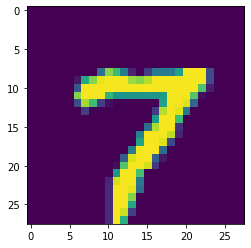

In [ ]:
plt.imshow(a[0][4,:,:,:].reshape(28,28))
a[1][4]

# Models

In [ ]:
# MODELS

import torch
import torch.nn as nn


class CVae(nn.Module):
    
    '''
    Class that models a generic  conditional varational autoencoder that takes an encoder and a decoder as input 
    and performs the encoding and decoding operation during the training using the reparameterization trick
    useful for the training backpropagation.

    In Pytorch the custom implementation of neural networks is carried out by selling the class nn.Module.

    Attributes
    ----------
    encoder : Encoder
        Encoder to perform the encoding task for the varational autoencoder. 
        The encoder will only be of the convolutional type.

    decoder : Decoder
        Decoder to perform the decoding task for the varational autoencoder.
        The encoder will be either convolutional or recurrent (GRU + Linear).

    repar_type : str
        String that allows you to select one of the two present implementations of the reparametrization trick.
    '''

    
    def __init__(self, encoder : nn.Module, decoder : nn.Module, repar_type : str) -> None:
        '''
        Autoencoder constructor.

        Parameters
        ----------
        encoder : nn.Module
            Encoder type to perform the encoding part of varational autoencoder's task

        decoder : nn.Module
            Decoder type to perform the decoding part of varational autoencoder's task

        repar_type : str
            String to select the type of implementation of the proposed reparametrization trick.
        '''
        
        super().__init__()
        self.__encoder = encoder
        self.__decoder = decoder
        self.__repar_type = repar_type


        
    def encoder(self, x : torch.Tensor, y) -> (torch.Tensor, torch.Tensor):
        '''
        Method that performs the econding task according to the type of input encoder to the constructor.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing the input examples to be encoded in the latent space

        Returns
        -------
        encoder(x) : tuple of torch.Tensor
        '''
        
        return self.__encoder(x, y)


        
    def decoder(self, x : torch.Tensor, y) -> torch.Tensor:
        '''
        Method that performs the decoding task according to the type of input decoder to the constructor.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing the latent space to be reconstructed

        Returns
        -------
        decoder(x) : torch.Tensor
            Output tensor containing the decoder otuput (input reconstruction)
        '''

        return self.__decoder(x, y)


        
    def reparametrization1(self, mu : torch.Tensor, logvar : torch.Tensor) -> torch.Tensor:
        '''
        Method that implements the first version of the reparametrization trick which provides latent space 
        for a given input example.

        Parameters
        ----------
        mu : torch.Tensor
            Tensor containing the mean for the normal distribution according to the size of the latent space chosen.

        logvar : torch.Tensor
            Tensor containing the log-variance for the normal distribution according to the size of latent space chosen.
        

        Returns
        -------
        latent_mu : torch.Tensor
            The latent space re-sampled mean for normal distribution with fixed mean and standard deviation.

        mu : torch.Tensor
            The latent space mean previus obtained.
        '''
        
        if self.training:
            std = (logvar * 0.5).exp()
            return torch.distributions.Normal(loc=mu, scale=std).rsample()
        else:
            return mu

        
        
    def reparametrization2(self, mu : torch.Tensor, logvar : torch.Tensor) -> torch.Tensor:
        '''
        Method that implements the second version of the reparametrization trick which provides latent space 
        for a given input example.

        Parameters
        ----------
        mu : torch.Tensor
            Tensor containing the mean for the normal distribution according to the size of the latent space chosen.

        logvar : torch.Tensor
            Tensor containing the log-variance for the normal distribution according to the size of latent space chosen.
        

        Returns
        -------
        latent_mu : torch.Tensor
            the latent space re-sampled mean for normal distribution with fixed mean and standard deviation.

        mu : torch.Tensor
            the latent space mean previus obtained.
        '''
      
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = 1e-2 * torch.randn_like(std)
            w = eps.mul(std).add_(mu)
            return w
        else:
            return mu


        
    def forward(self, x : torch.Tensor, y ) -> (torch.Tensor, torch.Tensor, torch.Tensor):
        '''
        Inherited method that iterates the autoencoder task:
            - encoding
            - reparametrization (only in case of neural network training) 
            . decoding

        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing batch examples to process it.


        Returns
        -------
        (x_recon, latent_mu, latent_logvar) : tuple of torch.Tensor
            Output tuple of torch.Tensor containing: 
            - x_recon :  the reconstructed input batch examples x.
            - latent_mu : the latent mean obtained from encoder.
            - latent_logvar : the latent log-variance obtained from encoder.
        '''
        
        latent_mu, latent_logvar = self.encoder(x, y)

        if self.__repar_type == 'type1':
            latent = self.reparametrization1(latent_mu, latent_logvar)
        else:
            latent = self.reparametrization2(latent_mu, latent_logvar)
        x_recon = self.decoder(latent, y)
        return (x_recon, latent_mu, latent_logvar)
    

####################### CONV ENC-DEC ##########################################




import torch
import torch.nn as nn


class ConvEncoder(nn.Module):
    '''
    Class that models the convolutional neural network that plays the role of encoder. 
    It inherits the Pytorch nn.Module class by defining the various layers in the constructor and overriding 
    the forward method to define the actual behavior of the network during training.

    Attributes
    ----------
    conv1 : nn.Conv2d
        First layer that performs the 2D convolution.

    conv2 : nn.Conv2d
        Second layer that performs the 2D convolution.

    conv3 : nn.Conv2d
        Third layer that performs the 2D convolution.

    fc_mu : nn.Linear
        Linear layer that calculates the mean of the probability distribution of the latent space of the autoncoder.

    fc_logvar : nn.Linear
        Linear layer that calculates the log-variance of the probability distribution of the latent space of the autoncoder.

    activation : nn.ReLU or nn.SeLU
        Neural network activation function which can be ReLU or SeLU depending on what is chosen when the object is initialized.

    dropout : nn.Dropout
        Dropout layer to be applied to each output of the convolutional linear map (except the last layer).
    '''

    
    def __init__(self, in_channels : int, one_hot_columns : int,
                                          one_hot_rows : int,
                                          cond_dims : int,
                                          hidden_channels : int,
                                          latent_dim : int,
                                          kernel_size : int,
                                          stride : int,
                                          padding : int,
                                          activation_function : str,
                                          dropout : nn.Dropout2d = None) -> None:

        super().__init__()


        '''
        Parameters
        ----------
        in_channels : int
            Input channel size.

        one_hot_columns : int
            Column size of each one hot encoding matrix.
        
        one_hot_rows : int
            Row size of each one hot encoding matrix.

        hidden_channels : int
            Reference hidden channel size of the convolutional layers.

        latent_dim : int
            Latent space dimension size of autoencoder.
        
        kernel_size : int
            Square kernel size.

        stride : int
            Size of the stride in the convolution.

        padding : int
            Size of the padding around the matrix.

        activation_function : str
            String aimed at choosing whether to use the ReLU or SeLU activation function.

        dropout : nn.Dropout
            Dropout layer to be applied to each output of the convolutional linear map (except the last layer).
        '''
        
        
        #Two convolutional layer
        self.__conv1 = nn.Conv2d(in_channels = in_channels, 
                               out_channels = int(hidden_channels/2), 
                               kernel_size = kernel_size, 
                               stride = stride, 
                               padding = padding)

        self.__conv2 = nn.Conv2d(in_channels = int(hidden_channels/2), 
                               out_channels = hidden_channels, 
                               kernel_size = kernel_size, 
                               stride = stride, 
                               padding = padding)

        self.__conv3 = nn.Conv2d(in_channels = hidden_channels, 
                               out_channels = hidden_channels*2, 
                               kernel_size = kernel_size, 
                               stride = stride, 
                               padding = padding)
        
        self.__fc_mu = nn.Linear(in_features = hidden_channels*2*one_hot_rows*one_hot_columns + cond_dims,
                                 out_features = latent_dim)
        
        self.__fc_logvar = nn.Linear(in_features = hidden_channels*2*one_hot_rows*one_hot_columns + cond_dims,
                                 out_features = latent_dim)

        #Activation function
        if activation_function == "relu":
            self.__activation = nn.ReLU()
        elif activation_function == "selu":
            self.__activation = nn.SeLU()


        self.__dropout = dropout


        
    def forward(self, x : torch.Tensor, y=None) -> (torch.Tensor, torch.Tensor):
        '''
        Overriding the forward method which does:
            1.   The application of the 2d convolution as a linear map followed by the non-linear 
                 application of the ReLU (or SeLU) function.
            2.   The application of the 2d convolution as a linear map followed by the non-linear 
                 application of the ReLU (or SeLU) function.
            3.   The application of the 2d convolution as a linear map followed by the non-linear
                 application of the ReLU (or SeLU) function.
            4.1. The application of the linear layer as linear map for the latent mean calculation.
            4.2. The application of the linear layer as linear map for the log-variance calculation.


        Parameters
        ----------
        x : torch.Tensor
            Input data sample from the dataset.

        Returns
        -------
        (x_mu, x_logvar) : (torch.Tensor, torch.Tensor)
            Tuple of two tensors:
                - mean of the probability distribution of the latent space of the input sample x.
                - log-variance of the probability distribution of the latent space of the input sample x.
        '''  
        x_out = self.__activation(self.__conv1(x))
        if self.__dropout:
            x_out = self.__dropout(x_out)
            
        x_out = self.__activation(self.__conv2(x_out))
        if self.__dropout:
            x_out = self.__dropout(x_out)
            
        x_out = self.__activation(self.__conv3(x_out))
        if self.__dropout:
            x_out = self.__dropout(x_out)

        x_out = x_out.contiguous().view(x_out.shape[0], -1)

        ### concatenating 
        if y is not None:
           y = y.reshape(y.shape[0], -1)
           concat_input = torch.cat(([x_out, y]), -1)
        else:
           concat_input = x_out 

        x_mu = self.__fc_mu(concat_input)
        x_logvar = self.__fc_logvar(concat_input)

        return (x_mu, x_logvar)


################ CONV - Decoder #######################################



class ConvDecoder(nn.Module):
    '''
    Class that models the convolutional neural network that plays the role of decoder. 
    It inherits the Pytorch nn.Module class by defining the various layers in the constructor 
    and overriding the forward method to define the actual behavior of the network during training.

    Attributes
    ----------
    one_hot_columns : int
        Column size of each one hot encoding matrix. 

    one_hot_rows : int
        Row size of each one hot encoding matrix.

    hidden_channels : int
        Reference hidden channel size of the convolutional layers

    fc : nn.Linear
        Linear layer that performs linear application from the latent space necessary for the autoencoder.

    conv1 : nn.ConvTranspose2d
        First layer that performs the 2D transposed convolution.

    conv2 : nn.ConvTranspose2d
        Second layer that performs the 2D transposed convolution.

    conv3 : nn.ConvTranspose2d
        Third layer that performs the 2D transposed convolution.

    activation : nn.ReLU or nn.SeLU
        Neural network activation function which can be ReLU or SeLU depending on what is chosen when the object is initialized.
    '''

    
    def __init__(self, in_channels : int, one_hot_columns : int,
                                          one_hot_rows : int,
                                          cond_dims : int,
                                          hidden_channels : int,
                                          latent_dim : int,
                                          kernel_size : int,
                                          stride : int,
                                          padding : int,
                                          activation_function : str) -> None:

        '''
        Parameters
        ----------
        in_channels : int
            Input channel size.

        one_hot_columns : int
            Column size of each one hot encoding matrix.
        
        one_hot_rows : int
            Row size of each one hot encoding matrix.

        hidden_channels : int
            Reference hidden channel size of the convolutional layers.

        latent_dim : int
            Latent space dimension size of autoencoder.
        
        kernel_size : int
            Square kernel size.

        stride : int
            Size of the stride in the convolution.

        padding : int
            Size of the padding around the matrix.

        activation_function : str
            String aimed at choosing whether to use the ReLU or SeLU activation function.
        '''

        super().__init__()

        self.__one_hot_columns = one_hot_columns
        self.__one_hot_rows = one_hot_rows
        self.__hidden_channels = hidden_channels


        #Linear layer from latent representation        
        self.__fc = nn.Linear(in_features = latent_dim + cond_dims,
                              out_features = hidden_channels*2*one_hot_columns*one_hot_rows )

        
        #Convolutional layers
        self.__conv1 = nn.ConvTranspose2d(in_channels = hidden_channels*2, 
                                          out_channels = hidden_channels, 
                                          kernel_size = kernel_size, 
                                          stride = stride, 
                                          padding = padding)
        
        self.__conv2 = nn.ConvTranspose2d(in_channels = hidden_channels, 
                                          out_channels = int(hidden_channels/2), 
                                          kernel_size = kernel_size, 
                                          stride = stride, 
                                          padding = padding)
        
        self.__conv3 = nn.ConvTranspose2d(in_channels = int(hidden_channels/2), 
                                          out_channels = in_channels, 
                                          kernel_size = kernel_size, 
                                          stride = stride, 
                                          padding = padding)
        

        #activation function
        if activation_function == "relu":
            self.__activation = nn.ReLU()
        elif activation_function == "selu":
            self.__activation = nn.SeLU()


            
    def forward(self, x : torch.Tensor, y = None) -> torch.Tensor:
        '''
        Overriding the forward method which does:
            1. Application of the linear map of the linear layer.
            2. The application of the 2d transposed convolution as a linear map followed by the non-linear 
               application of the ReLU (or SeLU) function for the first layer.
            3. The application of the 2d transposed convolution as a linear map followed by the non-linear 
               application of the ReLU (or SeLU) function for the second layer.
            4. The application of the 2d trasposed convolution as a linear map followed by the non-linear
               application of the sigmoid fuction for the third layer returning the decoding as output.

        
        Parameters
        ----------
        x : torch.Tensor
            Input tensor containing the latent space to be reconstructed.

        Returns
        -------
        x_out : torch.Tensor
            Output tensor containing the decoder otuput.
        '''
        ### concatenating 
        if y is not None:
           y = y.reshape(y.shape[0], -1)
           x_out = torch.cat(([x, y]), -1)
        else:
           x_out = x
        x_out = self.__fc(x_out)
        x_out = x_out.contiguous().view(x_out.size(0), self.__hidden_channels*2, self.__one_hot_columns, self.__one_hot_rows)
        x_out = self.__activation(self.__conv1(x_out))
        x_out = self.__activation(self.__conv2(x_out))
        x_out = torch.sigmoid(self.__conv3(x_out))
        return x_out

In [ ]:
#Hyperparameters

#Hidden channel dimension
HIDDEN_CHANNEL = 40

#Latent space dimension
LATENT_SPACE_DIM = 5

#Convolutional layer kernel size
KERNEL_SIZE = 3

#Stride is the number of pixels shifts over the input matrix
STRIDE = 1

#Padding size to add around the matrix.
PADDING = 1

In [ ]:
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")

In [ ]:
#Hyperparameters that vary depending on the training

reparametrization = 'type1'
# dropout = None

# reparametrization = 'type2'
dropout = nn.Dropout2d(p = 0.2)

In [ ]:
# c['X'].shape

In [ ]:
conv_encoder = ConvEncoder(in_channels = 1, one_hot_columns = 28, #c['X'].shape[2],  #60
                                                    one_hot_rows = 28, #c['X'].shape[3], # 35
                                                    cond_dims = 10,
                                                    hidden_channels = HIDDEN_CHANNEL,
                                                    latent_dim = LATENT_SPACE_DIM,
                                                    kernel_size = KERNEL_SIZE,
                                                    stride = STRIDE,
                                                    padding = PADDING,
                                                    activation_function = 'relu',
                                                    dropout = dropout) 

conv_decoder = ConvDecoder(in_channels = 1, one_hot_columns = 28, #c['X'].shape[2], 
                                                    one_hot_rows = 28, # c['X'].shape[3], 
                                                    cond_dims = 10,
                                                    hidden_channels = HIDDEN_CHANNEL,
                                                    latent_dim = LATENT_SPACE_DIM,
                                                    kernel_size = KERNEL_SIZE,
                                                    stride = STRIDE,
                                                    padding = PADDING,
                                                    activation_function = 'relu')

conv_vae = CVae(conv_encoder, conv_decoder, repar_type = reparametrization)

In [ ]:
print(conv_vae)

In [ ]:
optimizer = torch.optim.Adam(params=conv_vae.parameters(), lr=0.0023)

In [ ]:
# itm = next(iter(train_loader))
# itm["X"].shape

In [ ]:
# xx= itm["X"].float()
# y = conv_vae(xx)

In [ ]:
# y[1].shape

In [ ]:
import torch.nn.functional as F
def vae_loss_function(recon_x : torch.Tensor, x : torch.Tensor, mu : torch.Tensor, logvar : torch.Tensor) -> float:
    '''
    Loss function for the variational autoencoder.

    The loss function used is the binary cross entropy applied to the reconstructed sample x and the original one, 
    the result of which is added to the KL divergence, which makes it a varational autoencoder.

    Returns
    -------
    recon_loss + kldivergence : float
        Loss value calculated for the variational autoencoder.
    '''
    
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kldivergence


In [ ]:
conv_vae = conv_vae.to(device)

In [ ]:
# Training
#Number of epochs for training
NUM_EPOCHS = 35
for t in range(NUM_EPOCHS):
    for batch in trainldr: #train_loader:
        bloss = []
        # Feed forward to get the logits
        X, y= batch[0], batch[1]
        X, y = X.float(), y.float()
        # print(X.shape, y.shape)
        X,y = X.to(device), y.to(device)
        X_pred, latent_mu, latent_logvar = conv_vae(X, y)
        
        # Compute the loss (MSE)
        loss = vae_loss_function(X_pred, X, latent_mu, latent_logvar)
        # zero the gradients before running
        # the backward pass.
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient
        # of loss w.r.t our learnable params. 
        loss.backward()
        
        # Update params
        optimizer.step()
        bloss.append(loss.item())
    if t % 10==0:
        print("[EPOCH]: %i, [LOSS]: %.6f" % (t, np.array(bloss).mean()))   

[EPOCH]: 0, [LOSS]: 1819.520020
[EPOCH]: 10, [LOSS]: 1762.167847
[EPOCH]: 20, [LOSS]: 1748.402222
[EPOCH]: 30, [LOSS]: 1547.719238


In [ ]:
batch[1].shape 

torch.Size([16, 1, 10])

In [ ]:
v = torch.randn(1, LATENT_SPACE_DIM).to(device)
v.shape

torch.Size([1, 5])

In [ ]:
c = torch.tensor([[0.,0.,0.,0.,0.,1.,0.,0.,0.,0.]]).to(device)
c.shape, c

(torch.Size([1, 10]),
 tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], device='cuda:0'))

In [ ]:
o = conv_vae.decoder(v, c)
o =  o.cpu().detach().numpy()
o.shape

(1, 1, 28, 28)

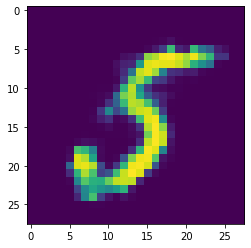

In [ ]:
plt.imshow(o[:,:,:,:].reshape(28, 28))